# Capstone Project: Comment Subtopics Analysis for Airbnb Hosts
---

How can a host on Airbnb understand that are their strengths and weaknesses? How can hosts point out the demand trend of their customers from a large scale of comments? This project focuses on using machine learning tools to help hosts understand the underlying trends of the comments on their property.  

---


# Part 4: Hidden Topics Analysis 
---

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

from gensim import corpora, models
import pyLDAvis.gensim
from langdetect import detect

pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(42)

In [2]:
reviews = pd.read_csv('../data/reviews_sentiment_score.csv', index_col = 0)

In [3]:
reviews.head()

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,overall_rating,compound,neg,neu,pos
0,0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",en,97.0,0.9590,0.000,0.788,0.212
1,1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,en,97.0,0.9819,0.000,0.697,0.303
2,2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,en,97.0,0.7600,0.134,0.710,0.156
3,3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,en,97.0,0.9840,0.035,0.646,0.319
4,4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,en,97.0,0.9617,0.000,0.613,0.387


In [4]:
listing = pd.read_csv('../data/listings/2019-03-06_data_listings.csv')

In [5]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20190306152813,2019-03-06,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,...,t,f,moderate,f,f,1,1,0,0,1.54
1,5858,https://www.airbnb.com/rooms/5858,20190306152813,2019-03-06,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.93
2,7918,https://www.airbnb.com/rooms/7918,20190306152813,2019-03-06,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.15
3,8142,https://www.airbnb.com/rooms/8142,20190306152813,2019-03-06,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,Nice and good public transportation. 7 minute...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.15
4,8339,https://www.airbnb.com/rooms/8339,20190306152813,2019-03-06,Historic Alamo Square Victorian,Pls email before booking. Interior featured i...,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.23


### Map Location To Listing 
---

In [6]:
location_dict = {}
for i, neighbourhood in zip(listing['id'],listing['neighbourhood_cleansed']):
    location_dict[i] = neighbourhood

In [7]:
len(location_dict)

7151

In [8]:
reviews['neighbourhood'] = reviews['listing_id'].map(location_dict)

In [9]:
reviews.head()

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,overall_rating,compound,neg,neu,pos,neighbourhood
0,0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",en,97.0,0.9590,0.000,0.788,0.212,Western Addition
1,1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,en,97.0,0.9819,0.000,0.697,0.303,Western Addition
2,2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,en,97.0,0.7600,0.134,0.710,0.156,Western Addition
3,3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,en,97.0,0.9840,0.035,0.646,0.319,Western Addition
4,4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,en,97.0,0.9617,0.000,0.613,0.387,Western Addition


In [10]:
reviews.sort_values(by = ['overall_rating'], ascending = False).head()

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,overall_rating,compound,neg,neu,pos,neighbourhood
111057,118846,3441949,257875081,2018-04-27,331641,SHireen,Amazing location to EVERYTHING!!\nI loved my s...,en,100.0,0.9790,0.000,0.615,0.385,Russian Hill
153942,164965,6600081,220292788,2017-12-21,130492142,Ping,Del’s place is absolutely amazing! It is centr...,en,100.0,0.8966,0.000,0.454,0.546,Mission
153934,164957,6600081,213716517,2017-11-22,32005301,AyJay,Fantastic stay overall!,en,100.0,0.9229,0.000,0.513,0.487,Mission
153935,164958,6600081,214336615,2017-11-25,5638600,Abrol,Absolutely great in all respects.,en,100.0,0.7960,0.114,0.557,0.329,Mission
153936,164959,6600081,214861636,2017-11-26,28140170,Sanem,Great place to stay.,en,100.0,0.9779,0.000,0.637,0.363,Mission


In [11]:
reviews[reviews['listing_id'] == 25094]['listing_id'].unique()[0]

25094

In [12]:
listing_avg_rating = reviews[["listing_id", "overall_rating"]].groupby(by = "listing_id").mean().reset_index()

In [13]:
listing_id = []
for i in listing_avg_rating[listing_avg_rating['overall_rating'] == 100]['listing_id']: 
    if reviews[reviews['listing_id'] == i].shape[0] < 100: 
        pass 
    else: 
        listing_id.append(reviews[reviews['listing_id'] == i]['listing_id'].unique()[0])

In [14]:
listing_id

[27025,
 561602,
 657121,
 909063,
 1110346,
 1421671,
 3081560,
 3333870,
 4558898,
 5068486,
 6560870,
 6600081,
 7022309,
 7180020,
 7327920,
 7998215,
 9196933,
 9347891,
 10437411,
 11104122,
 11191951,
 12562572,
 14745298,
 14996188,
 17222602,
 18994064,
 19015884,
 19331975,
 19403989,
 20695687,
 20762414,
 20803354]

## Create Hidden Topics Based On Previous LDA 
---

- 4 hidden topics people are talking about based on well-performing hosts showed up in LDA based on Sentiment and Review Score. 

- 3 hidden topics people are talking abotu based on poor-performing hosts showed up in LDA based on Sentiment and review Score.  

In [99]:
#Topic 1: Good Sentiment Words 
Good_sentiment_topic = ['great location', 'good experience', 'location great', 
                        'definitely stay', 'place stay', 
                        'great stay','great place', 'great time' ,'great value' ,
                        'definitely recommend' ,'recommend staying',
                        'highly recommended','highly recommend','recommend staying',
                        'recommend place','apartment great',
                        'enjoyed stay','recommend place','nice little','great value',
                        'loved stay','enjoyed stay','really enjoyed',
                        'really nice','place great','hayes valley','highly recommend',
                        'definitely recommend','definitely stay',
                        'stay time','amazing location','clean comfortable','clean great',
                        'feel welcome','enjoyed stay',
                        'place great','really great','place wonderful','great recommendations',
                        'overall great' ,'overall good' ,
                        'good stay' ,'exactly described', 'excellent','exceeded expectations', 'lovely']

In [100]:
#convinence
Convinence_topic = ['nice location', 
                    'easy check',
                    'easy',
                    'awesome location',
                    'centrally located',
                    'location perfect',
                    'great location',
                    'location great',
                    'walking distance',
                    'public transportation',
                    'public transport',
                    'golden gate',
                    'gate park',
                    'restaurants bars',
                    'local restaurants',
                    'shops restaurants',
                    'parking space',
                    'short walk',
                    'great spot',
                    'centrally located',
                    'great neighborhood',
                    'places eat',
                    'location beautiful',
                    'blocks away',
                    'street parking', 
                    'close',
                    'mins walk',
                    'short walk',
                    'bart station'] 

In [101]:
#Host Attitude 
Host_attitude_topic = ['helpful', 
                        'friendly',
                        'accommodating host',
                        'nice host',
                        'excellent host',
                        'friendly helpful',
                        'host great',
                        'great host',
                        'great hospitality',
                        'easy communicate',
                        'great communication',
                        'communication',
                        'quick respond',
                        'respond quesitions', 
                        'great hospitality',
                        'host highly',
                        'welcoming helpful',
                        'wonderful host',
                        'responsive']


In [102]:
#Amenities
Amenities_compliments = ['spacious', 
                    'clean',
                    'beautiful',
                    'nice',
                    'stylish',
                    'comfortable', 
                    'comfy beds', 
                    'comfy', 
                    'safe',
                    'quiet', 
                    'clean room',
                    'house clean',
                    'house beautiful',
                    'place clean',
                    'coffee morning',
                    'great apartment',
                    'bed comfortable',
                    'bed', 
                    'room clean',
                    'place amazing',
                    'great place',
                    'great restaurants',
                    'exactly described',
                    'places eat',
                    'apartment clean',
                    'place clean',
                    'sparkling clean',
                    'apartment beautiful',
                    'beautiful view',
                    'place beautiful',
                    'extremely clean',
                    'beautiful home',
                    'safe neighbourhood', 
                    'quiet place',
                    'great bathroom']

In [103]:
Cleaniness = ['clean', 
              'clean room',
              'house clean',
              'place clean', 
              'apartment clean',
              'place clean',
              'sparkling clean',
              'extremely clean']

In [105]:
#bad performiming topics 
#host cancelation keywords 
Host_calcelation = ['host canceled',
                    'automated posting',
                    'canceled reservation',
                    'reservation canceled']


In [106]:
#environment issue 
Environment_issue = ['homeless people',
                     'lot homeless',
                     'homeless', 
                     'drug', 
                     'mind neighborhood', 
                     'homeless population',
                     'heavy homeless', 
                     'lot homeless',
                     'unsafe neighborhood']



In [107]:
#bad Sentiment words 
Bad_sentiments = ['horrible', 'difficult', 'worst' ,'bad', 'poor', 
                  'dirty', 'congested', 'noisy', 'frustrating']

## Building Hidden Topic Relevancy Steps 
---

### Example Analysis on a 100 point, 5 stars hosts 

---

In [65]:
# 1. Combine all reviews and tokenize them 
list(reviews[reviews['listing_id'] == 27025]['comments'])

['The flat is beautiful, and fully and thoughtfully appointed.  The location is hard to beat too, just one block from Dolores Park.  And Luis is the sweetest host.  We enjoyed our stay very much.',
 "The flat is extremely well furnished with a large fridge + freezer (inc ice maker), a gas hob and range oven, microwave and plenty of work space. There is a dining area connected to the kitchen and a living area with a massive TV and extensive DVD collection.\r\n\r\nThe main double bedroom also includes a large TV and space for storing clothes, including hangars. Luis (who lives in a separate flat downstairs) even purchased an iron and ironing board specially at my request, which is always useful after using the separate washer and dryer also in the kitchen. Wifi worked perfectly in all rooms (Mac) and is a good speed.\r\n\r\nVarious useful items are included like soap, shampoo, toilet roll, washer tablets, assorted cooking items, cleaning products and anything you'd expect to have in your

In [66]:
#Use countvectorizer to get all features names with n_gram = 1 and 2 
cv = CountVectorizer(ngram_range= (1,2), 
                     stop_words= 'english', 
                     min_df = 2)

cv_transform = cv.fit_transform(list(reviews[reviews['listing_id'] == 27025]['comments']))

In [67]:
feature_list = cv.get_feature_names()

In [68]:
feature_list

['10',
 '10 minute',
 '100',
 '11',
 '12',
 '18',
 '30',
 'able',
 'able stay',
 'absolute',
 'absolutely',
 'absolutely gorgeous',
 'absolutely perfect',
 'access',
 'access city',
 'access public',
 'accessible',
 'accommodating',
 'accommodations',
 'action',
 'add',
 'added',
 'adorable',
 'advice',
 'agree',
 'aids',
 'air',
 'air bnb',
 'airbnb',
 'airbnb experience',
 'airbnb host',
 'airbnb rental',
 'airbnb stay',
 'airbnb ve',
 'airport',
 'airy',
 'amazing',
 'amazing host',
 'amazing place',
 'amazing stay',
 'amazingly',
 'amenities',
 'amenities great',
 'amenities need',
 'amenity',
 'answer',
 'answer questions',
 'anxious',
 'apartment',
 'apartment amazing',
 'apartment apartment',
 'apartment beautiful',
 'apartment clean',
 'apartment fantastic',
 'apartment gorgeous',
 'apartment great',
 'apartment located',
 'apartment lot',
 'apartment luis',
 'apartment really',
 'apartment rented',
 'apartment san',
 'apartment spacious',
 'appartement',
 'appliances',
 'appoi

In [108]:
good_sentiment = 0
convenience = 0 
host_attitude = 0 
amenities = 0 
cleaniness = 0
cancelation = 0
environment_problem = 0 
bad_sentiment = 0 

for word in feature_list: 
    if word in Good_sentiment_topic: 
        good_sentiment += 1 
    if word in Convinence_topic: 
        convenience += 1 
    if word in Host_attitude_topic: 
        host_attitude += 1 
    if word in Amenities_compliments: 
        amenities += 1 
    if word in Cleaniness: 
        cleaniness += 1 
    if word in host_calcelation: 
        cancelation += 1 
    if word in environment_issue: 
        environment_problem += 1 
    if word in bad_sentiments: 
        bad_sentiment += 1 

In [109]:
hidden_topic_df = pd.DataFrame(['good_sentiment', 'convenience', 'host_attitude', 'amenities' , 'cleaniness', 
              'cancelation', 'environment_problem', 'bad_sentiment'], columns = ['hidden_topic'])
hidden_topic_df['values'] = [good_sentiment, convenience, host_attitude, amenities ,cleaniness,  cancelation, environment_problem, bad_sentiment]

In [110]:
hidden_topic_df

,hidden_topic,values
0,good_sentiment,22
1,convenience,14
2,host_attitude,7
3,amenities,17
4,cleaniness,2
5,cancelation,0
6,environment_problem,0
7,bad_sentiment,1


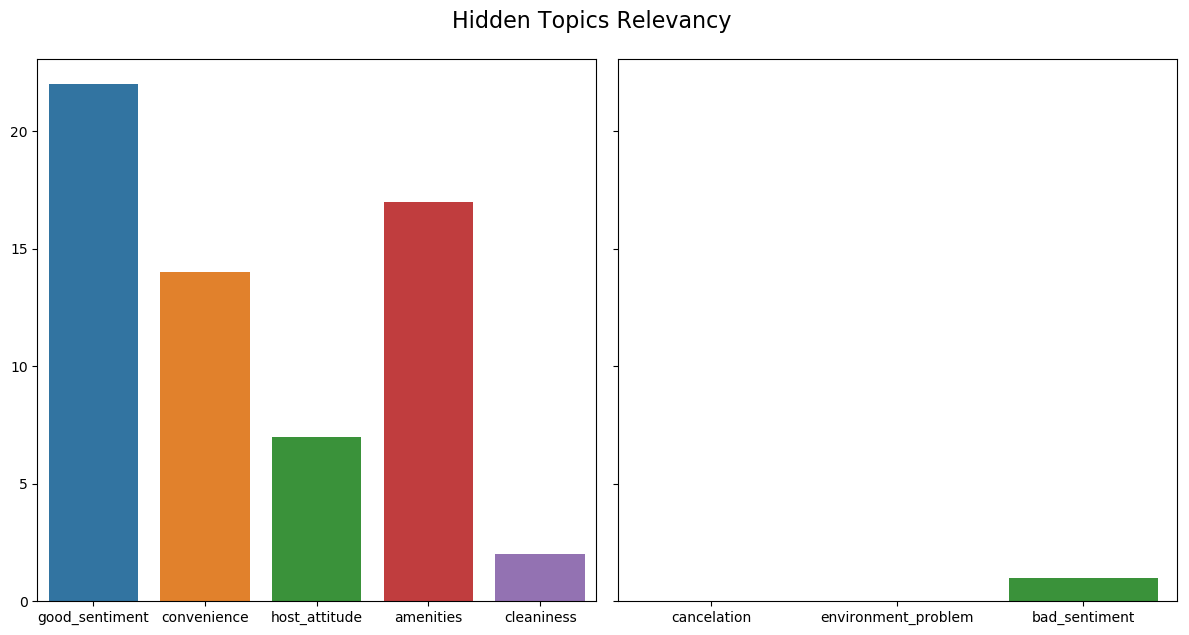

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), dpi=100, sharex= False, sharey=True)
colors = sns.color_palette("viridis", 2)

sns.barplot(x = ['good_sentiment', 'convenience', 'host_attitude', 'amenities', 'cleaniness'],
            y = [good_sentiment, convenience, host_attitude, amenities, cleaniness], 
            ax = axes[0])

sns.barplot(x = ['cancelation', 'environment_problem', 'bad_sentiment'],
            y = [cancelation, environment_problem, bad_sentiment], 
            ax = axes[1])

plt.suptitle('Hidden Topics Relevancy ', y=1.05, size=16)
plt.tight_layout();

### Example Analysis on a 100 point, 5 stars hosts 
---

In [140]:
reviews[reviews['overall_rating'] < 80]['listing_id'].unique()

array([   12042,    21914,    43778,    59831,    71779,    81256,
         351950,   366541,   741327,   781945,   830997,   872206,
        1229005,  1247160,  2931587,  4015985,  4317520,  5286782,
        5772013,  6338562,  6601749,  6898334,  6990507,  7323097,
        7666482,  7985260,  8908249,  8925997, 10127523, 10765781,
       11185685, 11242027, 11305302, 11439405, 11461771, 11886255,
       12753708, 12866962, 13204198, 13530616, 14075653, 14076194,
       14311906, 14373123, 14404663, 14468427, 15194258, 15321192,
       15377479, 15662354, 15677325, 15732801, 15990429, 15999214,
       16029428, 16071674, 16257289, 16394592, 16516970, 16632907,
       17716381, 17764344, 17807479, 18492773, 18519411, 18705363,
       18778187, 19038261, 19144925, 19211844, 19212255, 19586419,
       19813532, 19829202, 19904931, 19909235, 20614522, 20675281,
       20966756, 20967010, 20990167, 21115091, 21475672, 21488120,
       21503286, 21623317, 21634930, 21731528, 21772378, 21773

In [143]:
bad_host_list = []
for i in reviews[reviews['overall_rating'] < 80]['listing_id'].unique(): 
    if reviews[reviews['listing_id'] == i].shape[0] < 20:
        pass
    else:
        bad_host_list.append(i)      

In [144]:
bad_host_list

[15990429, 16029428, 16071674, 19211844, 19212255]

In [155]:
reviews[reviews['listing_id'] == 16029428].head()

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,overall_rating,compound,neg,neu,pos,neighbourhood
231561,248657,16029428,116078862,2016-11-27,105163979,Nikki,"Checking in/out was quick. Overall, good exper...",en,76.0,0.3064,0.000,0.862,0.138,Downtown/Civic Center
231562,248658,16029428,117062673,2016-12-04,60418666,Joseph,Just as advertised. Room was clean. Very sat...,en,76.0,0.9423,0.000,0.776,0.224,Downtown/Civic Center
231563,248659,16029428,117356401,2016-12-06,32077541,Arwen,While at night the surrounding neighborhood is...,en,76.0,0.9685,0.035,0.624,0.341,Downtown/Civic Center
231564,248660,16029428,120195892,2016-12-08,10113822,Tim,Fair value for the price. The only thing about...,en,76.0,0.9134,0.000,0.663,0.337,Downtown/Civic Center
231565,248661,16029428,120464842,2016-12-10,44210402,Dennis & Song,this is a great place to stay! i rate it 5 sta...,en,76.0,0.9176,0.000,0.633,0.367,Downtown/Civic Center


In [156]:
list(reviews[reviews['listing_id'] == 16029428]['comments'])

['Checking in/out was quick. Overall, good experience!.',
 "Just as advertised.  Room was clean.  Very satisfied with service.  This is a hotel.  Not someone's house or apartment.  Security is very good.  Akshay is very cordial and met me personally during my stay.  Had good advice for navigating the tenderloin.",
 'While at night the surrounding neighborhood is a bit unnerving once inside and during the day we felt completely safe. Easy check in check out. Rooms clean. Good value overall.',
 'Fair value for the price. The only thing about this listing - be aware this is located in Tenderloin District.',
 'this is a great place to stay! i rate it 5 stars for all aspects! it is like a hostel, friendly and helpful owners. location is super convenient! one of the cheapest rate i can find for next day availability.some review said the neighhood is not good, it may not be the best neighbouhood, which i agree, but for the price you pay, it is definitely great value for money. there are homel

In [163]:
#Use countvectorizer to get all features names with n_gram = 1 and 2 
cv = CountVectorizer(ngram_range= (1,2), 
                     stop_words= 'english', 
                     min_df = 2)

cv_transform = cv.fit_transform(list(reviews[reviews['listing_id'] == 16029428]['comments']))

In [164]:
feature_list = cv.get_feature_names()

In [165]:
good_sentiment = 0
convenience = 0 
host_attitude = 0 
amenities = 0 
cleaniness = 0
cancelation = 0
environment_problem = 0 
bad_sentiment = 0 

for word in feature_list: 
    if word in Good_sentiment_topic: 
        good_sentiment += 1 
    if word in Convinence_topic: 
        convenience += 1 
    if word in Host_attitude_topic: 
        host_attitude += 1 
    if word in Amenities_compliments: 
        amenities += 1 
    if word in Cleaniness: 
        cleaniness += 1 
    if word in host_calcelation: 
        cancelation += 1 
    if word in environment_issue: 
        environment_problem += 1 
    if word in bad_sentiments: 
        bad_sentiment += 1 

In [166]:
hidden_topic_df = pd.DataFrame(['good_sentiment', 'convenience', 'host_attitude', 'amenities' , 'cleaniness', 
              'cancelation', 'environment_problem', 'bad_sentiment'], columns = ['hidden_topic'])
hidden_topic_df['values'] = [good_sentiment, convenience, host_attitude, amenities ,cleaniness,  cancelation, environment_problem, bad_sentiment]

In [167]:
hidden_topic_df

,hidden_topic,values
0,good_sentiment,7
1,convenience,5
2,host_attitude,2
3,amenities,11
4,cleaniness,2
5,cancelation,0
6,environment_problem,5
7,bad_sentiment,5


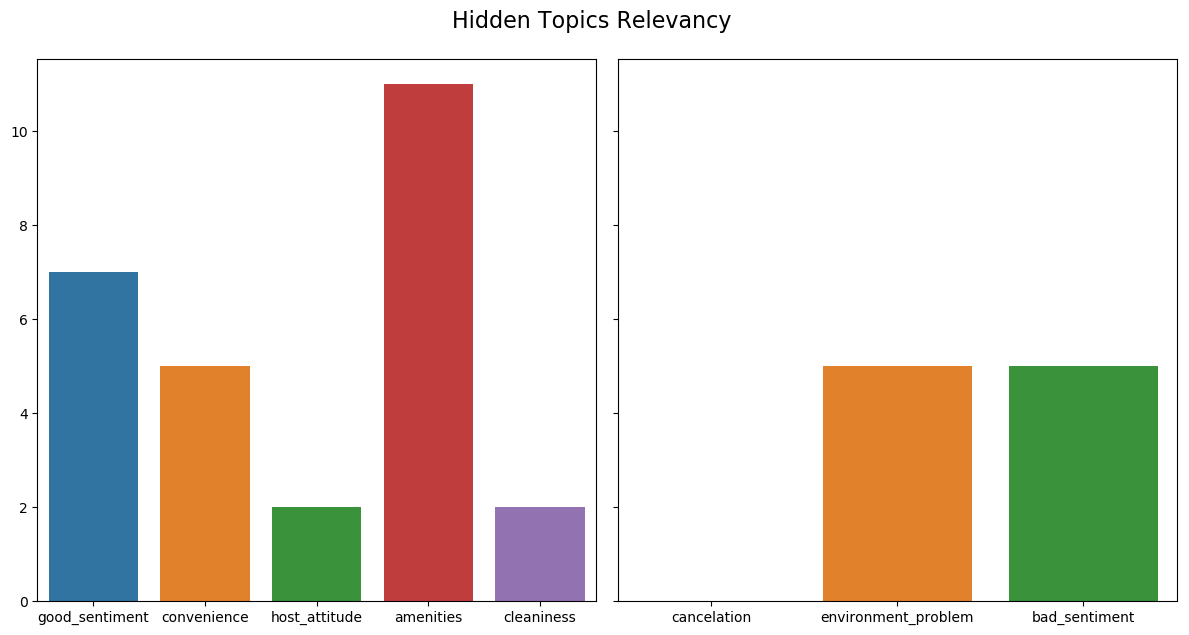

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), dpi=100, sharex= False, sharey=True)
colors = sns.color_palette("viridis", 2)

sns.barplot(x = ['good_sentiment', 'convenience', 'host_attitude', 'amenities', 'cleaniness'],
            y = [good_sentiment, convenience, host_attitude, amenities, cleaniness], 
            ax = axes[0])

sns.barplot(x = ['cancelation', 'environment_problem', 'bad_sentiment'],
            y = [cancelation, environment_problem, bad_sentiment], 
            ax = axes[1])

plt.suptitle('Hidden Topics Relevancy ', y=1.05, size=16)
plt.tight_layout();

## Build A Function for Conetent Based Hidden Topic Analysis

---

In [196]:
def hidden_topic_analysis(listing_id): 
    '''
    This function will take a listing id as an input, and then output the result of the result of hidden topic analysis
    based on the comments the host has. 
    output includes two parts: 
    1. number of comments 
    2. graph representing the relevancy of each hidden topcis
    '''
    #import reviews dataframe 
    reviews = pd.read_csv('../data/reviews_sentiment_score.csv', index_col = 0)
    
    #countvectorize the comments given listing id
    cv = CountVectorizer(ngram_range= (1,2), 
                     stop_words= 'english', 
                     min_df = 2)

    cv_transform = cv.fit_transform(list(reviews[reviews['listing_id'] == listing_id]['comments']))

    feature_list = cv.get_feature_names()
    
    #gather number of comments 
    n_comments = len(list(reviews[reviews['listing_id'] == listing_id]['comments']))
    
    #finding relevancy of the hidden topics 
    good_sentiment = 0
    convenience = 0 
    host_attitude = 0 
    amenities = 0 
    cleaniness = 0
    cancelation = 0
    environment_problem = 0 
    bad_sentiment = 0 

    for word in feature_list: 
        if word in Good_sentiment_topic: 
            good_sentiment += 1 
        if word in Convinence_topic: 
            convenience += 1 
        if word in Host_attitude_topic: 
            host_attitude += 1 
        if word in Amenities_compliments: 
            amenities += 1 
        if word in Cleaniness: 
            cleaniness += 1 
        if word in host_calcelation: 
            cancelation += 1 
        if word in environment_issue: 
            environment_problem += 1 
        if word in bad_sentiments: 
            bad_sentiment += 1 

    #building hidden topic dataframe 
    hidden_topic_df = pd.DataFrame(['good_sentiment', 'convenience', 'host_attitude', 'amenities' , 'cleaniness', 
                  'cancelation', 'environment_problem', 'bad_sentiment'], columns = ['hidden_topic'])
    hidden_topic_df['values'] = [good_sentiment, convenience, host_attitude, amenities ,cleaniness,  cancelation, environment_problem, bad_sentiment]

    #building hidden topic histogram
    fig, axes = plt.subplots(1, 2, figsize=(12,6), dpi=100, sharex= False, sharey=True)
    colors = sns.color_palette("viridis", 2)

    sns.barplot(x = ['good_sentiment', 'convenience', 'host_attitude', 'amenities', 'cleaniness'],
                y = [good_sentiment, convenience, host_attitude, amenities, cleaniness], 
                ax = axes[0])

    sns.barplot(x = ['cancelation', 'environment_problem', 'bad_sentiment'],
                y = [cancelation, environment_problem, bad_sentiment], 
                ax = axes[1])

    plt.suptitle('Hidden Topics Relevancy ', y=1.05, size=16)
    plt.tight_layout();
    
    print(f'Host with Listing ID : {listing_id} has {n_comments} comments')
    print(hidden_topic_df)
    
    return hidden_topic_df, fig 

In [197]:
bad_host_list

[15990429, 16029428, 16071674, 19211844, 19212255]

Host with Listing ID : 19212255 has 30 comments
          hidden_topic  values
0       good_sentiment       3
1          convenience       1
2        host_attitude       0
3            amenities       5
4           cleaniness       1
5          cancelation       0
6  environment_problem       3
7        bad_sentiment       3


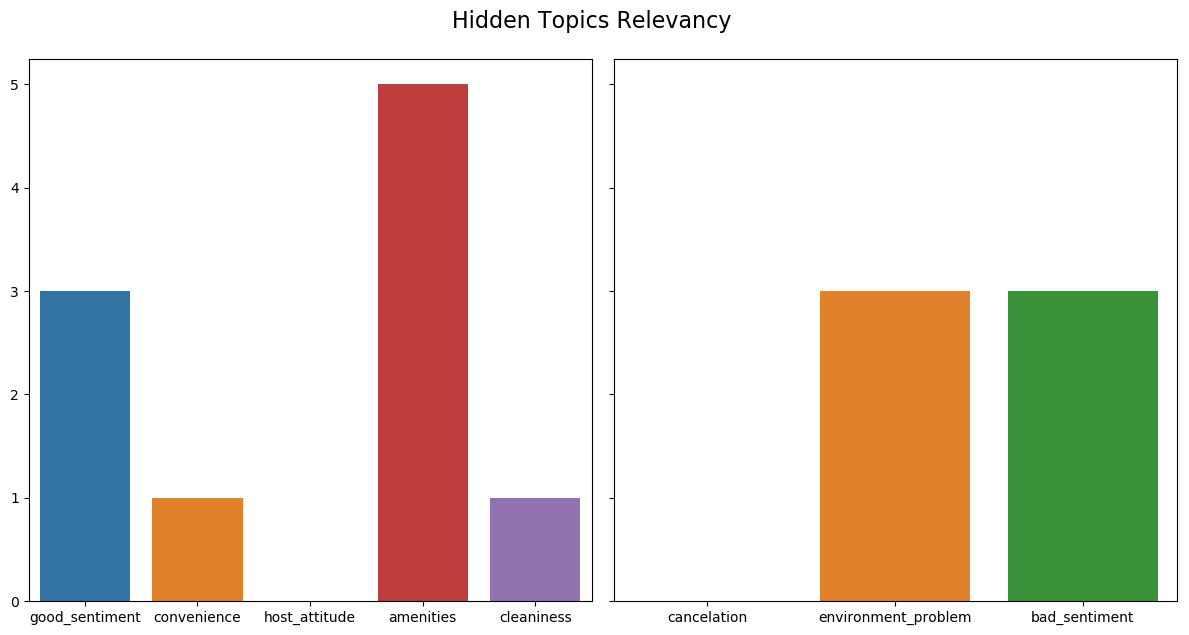

In [198]:
hidden_topic_df, fig = hidden_topic_analysis(19212255)